# Example of running and analysing the energy system model of the NL

In [1]:
import calliope
import pandas as pd

calliope.set_log_verbosity("INFO", include_solver_output=True)

## 1. Create and solve the model

In [2]:
model = calliope.Model('model/model.yaml')

[2024-12-18 16:48:00] INFO     Model: initialising
[2024-12-18 16:48:00] INFO     Model: preprocessing stage 1 (model_run)
[2024-12-18 16:48:02] WARNING  ModelWarning: Possibly missing data on the timesteps dimension for:
techs         nodes                 
demand_power  NLD    sink_use_equals    True
dtype: object

[2024-12-18 16:48:03] INFO     Model: preprocessing stage 2 (model_data)
[2024-12-18 16:48:03] INFO     Model: preprocessing complete


In [3]:
model.build()
model.solve()

[2024-12-18 16:48:03] INFO     Model: backend build starting
[2024-12-18 16:48:03] INFO     Optimisation Model | parameters | Generated.
[2024-12-18 16:48:04] INFO     Optimisation Model | variables | Generated.
[2024-12-18 16:48:05] INFO     Optimisation Model | global_expressions | Generated.
[2024-12-18 16:48:11] INFO     Optimisation Model | constraints | Generated.
[2024-12-18 16:48:11] INFO     Optimisation Model | piecewise_constraints | Generated.
[2024-12-18 16:48:11] INFO     Optimisation Model | objectives | Generated.
[2024-12-18 16:48:11] INFO     Model: backend build complete
[2024-12-18 16:48:11] INFO     Optimisation model | starting model in plan mode.
[2024-12-18 16:48:25] DEBUG    Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-24
[2024-12-18 16:48:26] DEBUG    Read LP format model from file C:\Users\guusd\AppData\Local\Temp\tmph3rr34u1.pyomo.lp
Reading time = 0.54 seconds
x1: 271553 rows, 122654 columns, 635203 nonzeros
Set pa

## 2. Do a first sense-check of the results

In [4]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2019-01-01 00:00:00       0.007982
1   NLD    power 2019-01-01 01:00:00       0.007982
2   NLD    power 2019-01-01 02:00:00       0.007982
3   NLD    power 2019-01-01 03:00:00            0.0
4   NLD    power 2019-01-01 04:00:00            0.0

<Axes: >

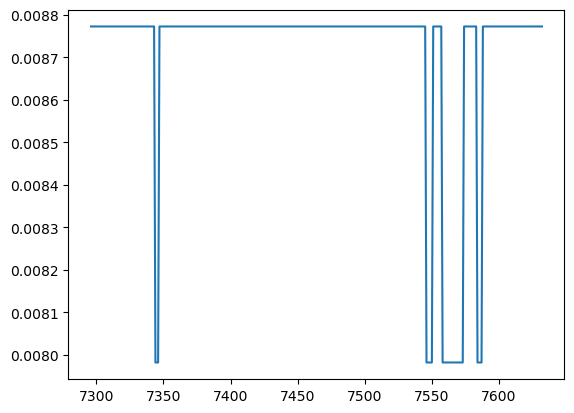

In [5]:
# Create a Date Range to select a few days in November to inspect visually
days_of_interest = pd.date_range('2019-11-01','2019-11-15',freq='H') 
# Plot the days of interest
balance_price['system_balance'].loc[balance_price['timesteps'].isin(days_of_interest)].plot()

Because the model is very simple, the price always matches the price of the CCGT unless renewables are capable of meeting demand by themselves. We can check that the value shown in the shadow price is indeed the marginal cost of the CCGT by performing a few steps. The marginal cost is, in fact, the ratio between the variable co

In [6]:
variable_costs = model.results.cost_var.to_series().dropna()
variable_costs.head()

nodes  techs  costs     timesteps          
NLD    ccgt   monetary  2019-01-01 00:00:00    48.287554
                        2019-01-01 01:00:00    31.315345
                        2019-01-01 02:00:00    10.679754
                        2019-01-01 03:00:00     0.000000
                        2019-01-01 04:00:00     0.000000
Name: cost_var, dtype: float64

In [7]:
generation = model.results.flow_out.to_series().dropna()
generation.head()

nodes  techs  carriers  timesteps          
NLD    ccgt   power     2019-01-01 00:00:00    6049.2100
                        2019-01-01 01:00:00    3923.0212
                        2019-01-01 02:00:00    1337.9032
                        2019-01-01 03:00:00       0.0000
                        2019-01-01 04:00:00       0.0000
Name: flow_out, dtype: float64

In [8]:
# If we calculate the marginal generation costs per generator type,
# we should see an equivalence between the shadow price in any given
# hour and the marginal cost of the marginal generator in the merit order
marginal_generation_costs = variable_costs/generation
marginal_generation_costs.head()

nodes  techs  timesteps            costs     carriers
NLD    ccgt   2019-01-01 00:00:00  monetary  power       0.007982
              2019-01-01 01:00:00  monetary  power       0.007982
              2019-01-01 02:00:00  monetary  power       0.007982
              2019-01-01 03:00:00  monetary  power            NaN
              2019-01-01 04:00:00  monetary  power            NaN
dtype: float64

As expected, the marginal cost of CCGT equals the shadow price. CCGT is the marginal generator in the merit order.

In [9]:
# To check the merit order, we may look at a particular timestep
# and at the list of generators producing in that timestep in ascending cost order.
# The per-timestep selection is easier done before transforming to a Pandas series.
marginal_generation_costs_xr = model.results.cost_var / model.results.flow_out
# We select a specific hour of the year
my_timestep = '2019-01-01 04:00:00'
# And we select only generators, excluding curtailment and other techs
gen_techs = ['solar_pv' ,'wind_offshore', 'wind_onshore', 'ccgt', 'nuclear'] 
# We can now inspect the marginal generation cost in that timestep
marginal_generation_cost_in_timestep = marginal_generation_costs_xr.sel(timesteps=my_timestep, carriers='power', costs='monetary', techs=gen_techs)
marginal_generation_cost_in_timestep.to_series().fillna(0).sort_values()

nodes  techs        
NLD    solar_pv         0.000000
       ccgt             0.000000
       nuclear          0.000000
       wind_offshore    0.001508
       wind_onshore     0.001508
dtype: float64

We see that CCGT, whose marginal generation costs match the shadow price, is the marginal generator. Nuclear isn't used; if it were, the shadow price would be higher and equal to its marginal cost. This can be double-checked by looking at the dispatch plots in Calligraph.

## 3. Export the results for further analysis at any later moment

In [10]:
# It is helpful to store the model results as a whole in NetCDF format, which Calliope can import back
# at any later time. 
model.to_netcdf('results/default_results.nc')

In [11]:
# Alternatively, results can be exported as a series of .csv files for inspection and analysis in Excel or
# other software that may benefit from .csv data
#model.to_csv('results/default_results_csv')

## 4. Produce some visualisations

The __easiest and recommended option__ to look at results visually is to use the __Calligraph__ interface

In [12]:
#! calligraph results/default_results.nc --port 32139

In [ ]:
! calligraph results/default_results.nc --port 12179

If, for any reasons, you prefer plotting by yourself outside of Calligraph, that's also possible.
In this example, we provide some pre-made plotting functionalities in the 'plotting_utilities.py' file, which you can import and apply as well as use as an example for making your own custom plots.

In [11]:
# Import some pre-made plotting functionalities as an example. You can use these, make your own, or simply
# create plots with your favourite Python library or non-Python tool, such as Excel
from plotting_utilities import plot_dispatch, plot_capacity, plot_load_duration_curve

In [19]:
# Dispatch and capacity plots can be generated directly from the saved model results
plot_dispatch(model_path='results/default_results.nc', plot_export_path='results/default_dispatch.html')
plot_capacity(model_path='results/default_results.nc', plot_export_path='results/default_capacity.html')

[2024-12-18 16:54:00] INFO     Model: initialising
[2024-12-18 16:54:00] INFO     Model: loaded model_data


[2024-12-18 16:54:01] INFO     Model: initialising
[2024-12-18 16:54:01] INFO     Model: loaded model_data


In [15]:
# For generating load duration curves (LDCs), instead, we first need to import back the model results,
# then extract the time-varing variable of interest
model = calliope.read_netcdf('results/default_results.nc')

[2024-12-18 16:52:27] INFO     Model: initialising
[2024-12-18 16:52:27] INFO     Model: loaded model_data


In [16]:
# Suppose we want to plot the LDC of the dispatch of the CCGT power plant
ccgt_dispatch = model.results.flow_out.sel(techs='ccgt').to_series().dropna()
ccgt_dispatch.head()

nodes  carriers  timesteps          
NLD    power     2019-01-01 00:00:00    6049.2100
                 2019-01-01 01:00:00    3923.0212
                 2019-01-01 02:00:00    1337.9032
                 2019-01-01 03:00:00       0.0000
                 2019-01-01 04:00:00       0.0000
Name: flow_out, dtype: float64

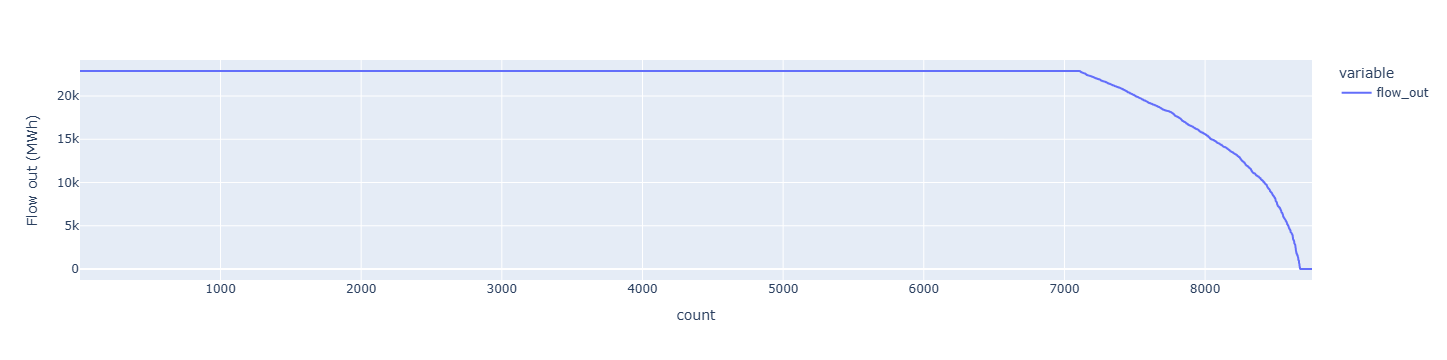

In [17]:
plot_load_duration_curve(dataframe=ccgt_dispatch.to_frame(), 
                         plot_export_path='results/default_ccgt_ldc.html', 
                         y_label='Flow out (MWh)')

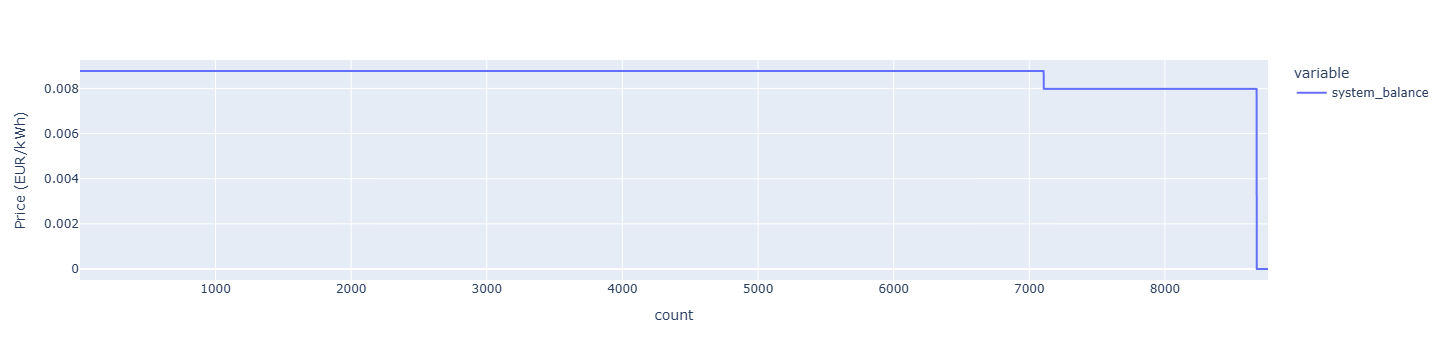

In [18]:
# Or we may want the LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

## 5. Apply a carbon tax scenario

In [1]:
import calliope
import pandas as pd

calliope.set_log_verbosity("INFO", include_solver_output=True)
model = calliope.Model('model/model.yaml',scenario='high_co2_price_high_gas_price')

[2024-12-18 16:06:37] INFO     Model: initialising
[2024-12-18 16:06:37] INFO     Loading overrides from scenario: high_co2_price_high_gas_price 
[2024-12-18 16:06:37] INFO     (scenarios, high_co2_price_high_gas_price ) | Applying the following overrides: ['high_co2_price', 'high_gas_price'].
[2024-12-18 16:06:37] INFO     Model: preprocessing stage 1 (model_run)
[2024-12-18 16:06:40] WARNING  ModelWarning: Possibly missing data on the timesteps dimension for:
techs         nodes                 
demand_power  NLD    sink_use_equals    True
dtype: object

[2024-12-18 16:06:40] INFO     Model: preprocessing stage 2 (model_data)
[2024-12-18 16:06:40] INFO     Model: preprocessing complete


In [2]:
model.build()
model.solve()

[2024-12-18 16:06:40] INFO     Model: backend build starting
[2024-12-18 16:06:41] INFO     Optimisation Model | parameters | Generated.
[2024-12-18 16:06:41] INFO     Optimisation Model | variables | Generated.
[2024-12-18 16:06:43] INFO     Optimisation Model | global_expressions | Generated.
[2024-12-18 16:06:49] INFO     Optimisation Model | constraints | Generated.
[2024-12-18 16:06:49] INFO     Optimisation Model | piecewise_constraints | Generated.
[2024-12-18 16:06:49] INFO     Optimisation Model | objectives | Generated.
[2024-12-18 16:06:49] INFO     Model: backend build complete
[2024-12-18 16:06:49] INFO     Optimisation model | starting model in plan mode.
[2024-12-18 16:07:03] DEBUG    Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-24
[2024-12-18 16:07:03] DEBUG    Read LP format model from file C:\Users\guusd\AppData\Local\Temp\tmp55kp9fbg.pyomo.lp
Reading time = 0.49 seconds
x1: 271553 rows, 122654 columns, 635203 nonzeros
Set pa

In [8]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2019-01-01 00:00:00       0.008772
1   NLD    power 2019-01-01 01:00:00       0.008772
2   NLD    power 2019-01-01 02:00:00       0.008772
3   NLD    power 2019-01-01 03:00:00            0.0
4   NLD    power 2019-01-01 04:00:00            0.0

We see that the shadow price changes and it is higher than in the default case, as expected.
We can visualise its LDC again:

In [9]:
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

NameError: name 'plot_load_duration_curve' is not defined

In [ ]:
# To calculate the merit order, we want to look at a particular timestep
# and at the list of generators producing in that timestep in ascending cost order.
# The per-timestep selection is easier done before transforming to a Pandas series.
marginal_generation_costs_xr = model.results.cost_var / model.results.flow_out
my_timestep = '2019-01-01 04:00:00'
gen_techs = ['solar_pv' ,'wind_offshore', 'wind_onshore', 'ccgt', 'nuclear'] # We select only generators, excluding curtailment and other techs
marginal_generation_cost_in_timestep = marginal_generation_costs_xr.sel(timesteps=my_timestep, carriers='power', techs=gen_techs)
marginal_generation_cost_in_timestep.to_series().fillna(0).sort_values()

We see that, in this case, the shadow price matches the marginal cost of the nuclear power plant. Nuclear is the marginal generator

In [3]:
model.to_netcdf('results/carbontax_results.nc')

## 6. Examine how results change also visually 

Again, the recommended option is to use __Calligraph__

In [ ]:
! calligraph results/carbontax_results.nc --port 54998

Alternatively, as before, you may use the plotting utilities or your own custom code

In [ ]:
# Dispatch and capacity plots can be generated directly from the saved model results
plot_dispatch(model_path='results/carbontax_results.nc', plot_export_path='results/carbontax_dispatch.html')
plot_capacity(model_path='results/carbontax_results.nc', plot_export_path='results/carbontax_capacity.html')

[2024-12-16 13:14:16] INFO     Model: initialising
[2024-12-16 13:14:16] INFO     Model: loaded model_data


The capacity plot does not change: nuclear was there in the default scenario, and it's here again, given that the system design is fixed and we only look at the dispatch. However, nuclear power is now in the dispatch, which wasn't the case before.
This is the effect of the carbon tax, which is making CCGT less attractive!